# Setup - Run these cells first
This section includes the needed imports and the functions already implemented during the in-class exercises.

In [1]:
!pip install swig
!pip install gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 40.9 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
from torch.distributions.normal import Normal
from torch.optim import Adam
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from datetime import datetime
from typing import Sequence
from tqdm import tqdm

In [3]:
def mlp(sizes: Sequence[int], activation=nn.ReLU, output_activation=nn.Identity) -> nn.Sequential:
  """
  Create a simple feedforward neural network.
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  layers = []
  for j in range(len(sizes)-1):
    act = activation if j < len(sizes)-2 else output_activation
    layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
  return nn.Sequential(*layers)

In [4]:
def get_policy(obs: torch.Tensor) -> Normal: #can be used to get P(a | state)
  """
  Get the stochastic policy for a given observation (-batch).
  Returns a distribution for every action.
  """
  obs = obs.unsqueeze(0) if obs.dim() == 1 else obs  # for single observations that do not have a batch dimension
  #vector in the form [batch1, ... , batch N], i need to unsqueze to bring it back to a 2D
  logits = policy_net(obs)
  mean, logstd = logits[:, :n_acts], logits[:, n_acts:]  # split the output layer into mean and logstd
  logstd = torch.clamp(logstd, min=-20, max=2)  # for numerical stability
  return Normal(mean, torch.exp(logstd)) #return the distribution over actions

In [5]:
def compute_loss(obs: torch.Tensor, act: torch.Tensor, weights: torch.Tensor) -> torch.Tensor:
  """
  Compute the REINFORCE loss for a given batch.
  """
  dist = get_policy(obs) #this retunrs me a set of P(act | obs)
  logp = dist.log_prob(act).sum(dim=-1) #here i am computing log(P(act | obs)) for the particular realization that occurred in my set
  return -(logp * weights).mean() #weights should be the discounted returns, mean over the trajectory, in this case a batch of .

In [6]:
def discounted_return(arr: Sequence[float]) -> list[float]:
  """
  Compute the discounted return for a single episode, given a sequence of rewards.
  """
  ret = [0.0] * len(arr) #this line creates an array of length len(arr) of zeros
  ret[-1] = arr[-1] #the G_T is set to zero
  for i in range(len(arr)-2, -1, -1): #for each
    ret[i] = arr[i] + gamma * ret[i+1]# G_t = R_t + gamma*G_(t+1) but we are moving backwads --> G_(t+1) = ret[i+1]
  return ret

In [7]:
def get_action(obs: torch.Tensor) -> np.ndarray:
  """
  Sample an action from the policy for a given observation.

  This function is used during environment interaction to select actions.

  Args:
      obs: Observation tensor of shape (obs_dim,)

  Returns:
      action: Numpy array of shape (n_acts,) sampled from the policy

  Hint: Use get_policy() to get the distribution, then sample from it.
  Hint: Remember to convert from torch.Tensor to numpy array and remove batch dimension.
  """
  distr = get_policy(obs)
  #now i have my distribution over the action set i need a sample from it
  actions = distr.sample()
  #need to convert them in a numpy array
  np_arr = actions.squeeze().detach().cpu().numpy() #standard formulation to convert torch tensor to numpy array
  return np_arr

# EXERCISE 2: Implement train_one_epoch

In [8]:
def train_one_epoch() -> tuple[list, list]:
  """
  Train the policy for one epoch (one policy update).

  This function:
  1. Collects a batch of experience by running episodes
  2. Computes returns-to-go for each timestep
  3. Normalizes the returns (for stable learning)
  4. Computes the loss and updates the policy

  Returns:
      batch_rets: List of episode returns
      batch_lens: List of episode lengths

  Global variables you'll need:
  - env: The gymnasium environment
  - batch_size: Number of timesteps to collect
  - gamma: Discount factor
  - optimizer: The optimizer for updating policy_net

  Functions you'll use:
  - get_action(obs): Sample action from policy
  - discounted_return(rewards, gamma): Compute returns-to-go
  - compute_loss(obs, acts, weights): Compute policy gradient loss

  Hint: Look at the structure from the tutorial slides/video.
  Hint: Don't forget to normalize the weights (returns-to-go) before computing loss.
  Hint: Remember the standard optimization steps: zero_grad(), backward(), step()
  """
  global env, policy_net, batch_size, gamma, optimizer

  #1. Collects a batch of experience by running episodes
  batch_obs = []      # Observations
  batch_acts = []     # Actions
  batch_weights = []  # Discounted Returns
  batch_rets = [] #To store total return of each episode
  batch_lens = [] #to store the length of each episode
  while len(batch_obs) < batch_size:
    # Temporary lists for the current episode
    ep_obs = []
    ep_acts = []
    ep_rewards = []
    ep_length = []
    obs, _ = env.reset() #reset the environment returns a new initial state
    while True:
      ep_obs.append(obs)
      obs_tensor = torch.as_tensor(obs, dtype=torch.float32).to(device) #to get the action I need a torch tensor
      action = get_action(obs_tensor)
      ep_acts.append(action)
      obs, rew, terminated,truncated, _ = env.step(action)
      ep_rewards.append(rew)
      if terminated or truncated:
        break
    batch_obs.extend(ep_obs)
    batch_acts.extend(ep_acts)
    # 2. Computes returns-to-go for each timestep
    returns_to_go = discounted_return(ep_rewards)
    batch_weights.extend(returns_to_go)
    batch_rets.append(sum(ep_rewards))
    batch_lens.append(len(ep_rewards))

  #convert in to torch tensors for training
  batch_obs = torch.tensor(np.array(batch_obs), dtype=torch.float32).to(device)
  batch_acts = torch.tensor(np.array(batch_acts), dtype=torch.float32).to(device)
  batch_weights = torch.tensor(np.array(batch_weights), dtype=torch.float32).to(device)
  #  3. Normalizes the returns (for stable learning), set them in mean zero and variance 1
  if len(batch_weights) > 1: # Safety check
        batch_mean = batch_weights.mean()
        batch_std = batch_weights.std()
        batch_weights = (batch_weights - batch_mean) / (batch_std + 1e-8)

  #train the MLP
  policy_net.train()
  optimizer.zero_grad()
  loss = compute_loss(batch_obs,  batch_acts, batch_weights)
  loss.backward()
  optimizer.step()

  return batch_rets, batch_lens






# EXERCISE 3: Complete the Training Loop

/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
Training Phase:  20%|█▉        | 99/500 [08:59<28:01,  4.19s/it, avg_ret=-122.02, avg_len=103.41]/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
Training Phase: 100%|██████████| 500/500 [1:14:41<00:00,  8.96s/it, avg_ret=2.91, avg_len=430.75]


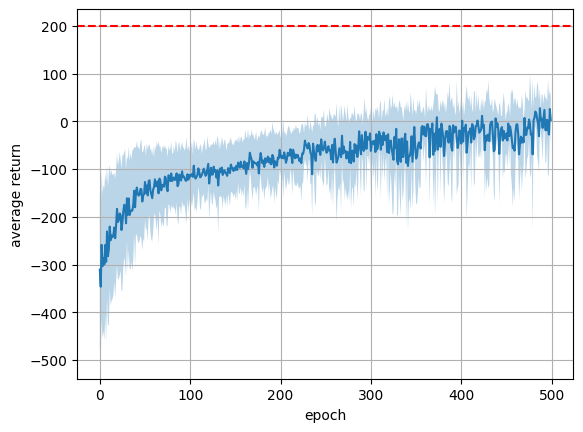

In [9]:
"""
Now you'll put everything together to train your REINFORCE agent!

Fill in the TODOs below to:
1. Set up the environment
2. Create the policy network
3. Create the optimizer
4. Run the training loop
5. Plot the results

This is the complete pipeline you'll use for experimentation in Exercise 4.
"""

# Hyperparameters
env_name = "LunarLander-v3"
hidden_sizes = [64, 64]
lr = 3e-4
epochs = 500  # You can increase this for better results
batch_size = 5000
gamma = 0.99
plot = True

#Create the environment
env = gym.make("LunarLander-v3", continuous = True, render_mode = "rgb_array")
env = gym.wrappers.RecordVideo(env, "video", video_length=1000)
#Get observation and action dimensions from the environment
#Use env.observation_space.shape[0] and env.action_space.shape[0]
obs_dim = env.observation_space.shape[0]
n_acts = env.action_space.shape[0]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Create the policy network using mlp()
#Input size is obs_dim, output size is 2*n_acts (for mean and logstd)
policy_net = mlp([obs_dim,64, 64, 2*n_acts])
policy_net.to(device)

#Create the optimizer
#Use Adam optimizer with the policy network parameters and learning rate
optimizer = Adam(policy_net.parameters(), lr = lr)

# Initialize tracking
returns = []
std = []

# --- 2. Funzione Helper per registrare (da mettere prima del loop) ---
def save_video_of_model(policy, env_name, epoch, device):
    """Crea un ambiente temporaneo, registra 1 episodio e chiude."""
    # Crea un env specifico per il video con un nome file che include l'epoca
    eval_env = gym.make(env_name, continuous=True, render_mode="rgb_array")
    eval_env = gym.wrappers.RecordVideo(
        eval_env,
        video_folder="video",
        name_prefix=f"video_epoch_{epoch}",
        disable_logger=True # Riduce il rumore nei log
    )

#Create a training loop that runs for 'epochs' iterations
#Use tqdm(range(1, epochs+1)) for a progress bar
# For each epoch:
#   - Call train_one_epoch() to get batch_rets and batch_lens
#   - Compute average return and episode length
#   - Append to returns list
#   - Append std of batch_rets to stds list
#   - Update progress bar with avg_ret and avg_len
with tqdm(range(1, epochs+1), desc="Training Phase") as pbar:
  for epoch in pbar:
    batch_rets, batch_lens = train_one_epoch()
    avg_ret = np.mean(batch_rets)
    avg_len = np.mean(batch_lens)
    returns.append(avg_ret)
    std.append(np.std(batch_rets))
    if epoch % 100 == 0 or epoch == epochs:
            save_video_of_model(policy_net, "LunarLander-v3", epoch, device)
    pbar.set_postfix({'avg_ret': f'{avg_ret:.2f}', 'avg_len': f'{avg_len:.2f}'})


if plot:
  plt.plot(returns)
  plt.fill_between(range(len(returns)), np.array(returns) - np.array(std), np.minimum(300, np.array(returns) + np.array(std)), alpha=0.3)
  plt.grid()
  goal = {"LunarLander-v3": 200, "BipedalWalker-v3": 300}.get(env_name, 0)
  plt.axhline(goal, color='r', linestyle='--')
  plt.xlabel('epoch')
  plt.ylabel('average return')
  timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
  plt.savefig(f"Reinforce_training_{timestamp}.png")
  plt.show()